<a href="https://colab.research.google.com/github/MizeroR/summative-model-training-2025/blob/main/Copy_of_Reine_Mizero_Summative_Assignment_Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RealWaste Image Classification: Traditional ML vs Deep Learning
# Dataset: 4752 images across 9 waste material categories from authentic landfill environment




# 1. SETUP AND IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Traditional ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: True


# 2. DOWNLOAD DATASET FROM UCI REPOSITORY


In [3]:
print("DOWNLOADING REALWASTE DATASET")

DATASET_URL = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"
DATASET_ZIP = "realwaste.zip"
EXTRACT_DIR = "realwaste_data"

print(f"\nDownloading dataset from: {DATASET_URL}")
print("This may take a few minutes depending on your connection...")

!wget -q --show-progress {DATASET_URL} -O {DATASET_ZIP}

print("\n✓ Download complete!")

DOWNLOADING REALWASTE DATASET

This may take a few minutes depending on your connection...
realwaste.zip           [              <=>   ] 656.65M  70.6MB/s    in 9.8s    

✓ Download complete!


In [4]:
# Extract dataset
print(f"\nExtracting dataset to: {EXTRACT_DIR}/")
!unzip -q {DATASET_ZIP} -d {EXTRACT_DIR}

print("✓ Extraction complete!")

# List downloaded files to understand structure
print("\nInspecting dataset structure...")
!ls -la {EXTRACT_DIR}

import os
from pathlib import Path

# Find the root directory containing class folders
def find_data_root(extract_dir):
    """Find the directory containing the actual image class folders"""
    for root, dirs, files in os.walk(extract_dir):
        # Check if this directory contains folders with our class names
        dir_names = [d.lower() for d in dirs]
        if any(cls.lower().replace(' ', '_') in dir_names or
               cls.lower().replace(' ', '-') in dir_names or
               cls.lower().replace(' ', '') in dir_names
               for cls in CLASS_LABELS):
            return root
    return extract_dir

DATA_ROOT = find_data_root(EXTRACT_DIR)
print(f"\nData root directory: {DATA_ROOT}")
print("\nDirectories found:")
!ls -la {DATA_ROOT}


Extracting dataset to: realwaste_data/
✓ Extraction complete!

Inspecting dataset structure...
total 12
drwxr-xr-x 3 root root 4096 Oct 17 07:35 .
drwxr-xr-x 1 root root 4096 Oct 17 07:35 ..
drwxr-xr-x 3 root root 4096 Dec  1  2023 realwaste-main

Data root directory: realwaste_data/realwaste-main/RealWaste

Directories found:
total 244
drwxr-xr-x 11 root root  4096 Dec  1  2023  .
drwxr-xr-x  3 root root  4096 Dec  1  2023  ..
drwxr-xr-x  2 root root 20480 Dec  1  2023  Cardboard
drwxr-xr-x  2 root root 20480 Dec  1  2023 'Food Organics'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Glass
drwxr-xr-x  2 root root 36864 Dec  1  2023  Metal
drwxr-xr-x  2 root root 28672 Dec  1  2023 'Miscellaneous Trash'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Paper
drwxr-xr-x  2 root root 36864 Dec  1  2023  Plastic
drwxr-xr-x  2 root root 20480 Dec  1  2023 'Textile Trash'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Vegetation


# 3. DATASET CONFIGURATION


In [5]:
CLASS_LABELS = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

# dataset parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = len(CLASS_LABELS)
DATASET_SIZE = 4752

# data directory
DATA_DIR = DATA_ROOT

print(f"\nDataset Configuration:")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Total Instances: {DATASET_SIZE}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Classes: {', '.join(CLASS_LABELS)}")
print(f"Data Directory: {DATA_DIR}")


Dataset Configuration:
Number of Classes: 9
Total Instances: 4752
Image Size: 224x224
Classes: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation
Data Directory: realwaste_data/realwaste-main/RealWaste


# 4. DATA LOADING AND EXPLORATION


✓ Found 461 images for 'Cardboard' in directory 'Cardboard'
✓ Found 411 images for 'Food Organics' in directory 'Food Organics'
✓ Found 420 images for 'Glass' in directory 'Glass'
✓ Found 790 images for 'Metal' in directory 'Metal'
✓ Found 495 images for 'Miscellaneous Trash' in directory 'Miscellaneous Trash'
✓ Found 500 images for 'Paper' in directory 'Paper'
✓ Found 921 images for 'Plastic' in directory 'Plastic'
✓ Found 318 images for 'Textile Trash' in directory 'Textile Trash'
✓ Found 436 images for 'Vegetation' in directory 'Vegetation'

Dataset loaded: 4752 images

Class Distribution:
class
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


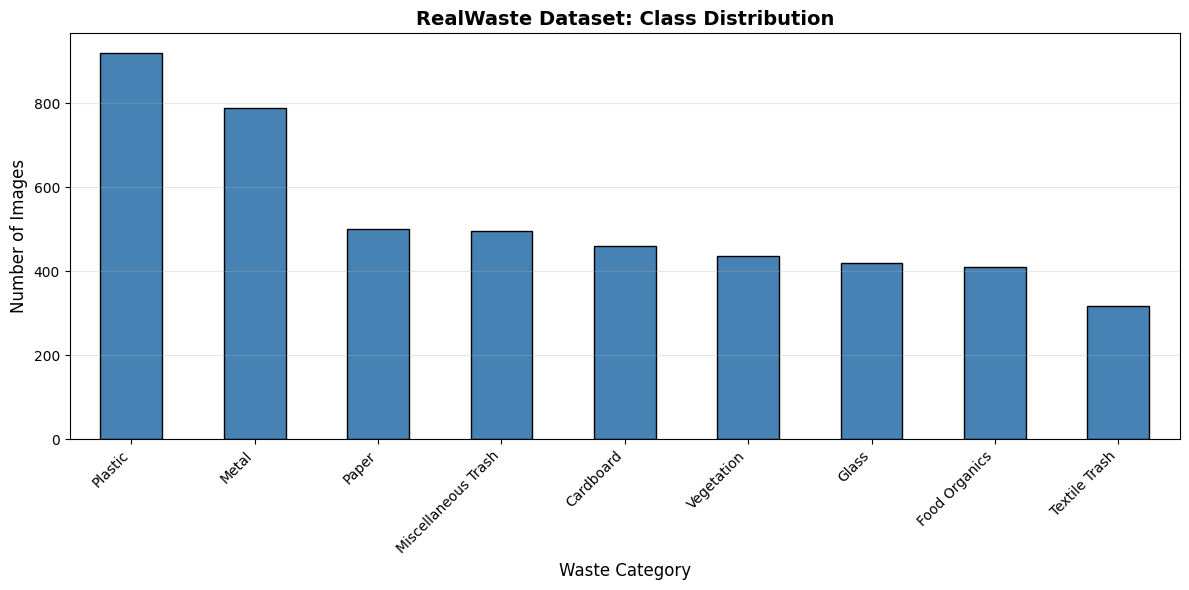


Class Balance Analysis:
Plastic: 19.38%
Metal: 16.62%
Paper: 10.52%
Miscellaneous Trash: 10.42%
Cardboard: 9.70%
Vegetation: 9.18%
Glass: 8.84%
Food Organics: 8.65%
Textile Trash: 6.69%

Imbalance Ratio: 2.90x
⚠️ Significant class imbalance detected - consider using class weights


In [6]:

def load_dataset_info(data_dir):
    """
    Load and explore dataset structure
    Handles different possible naming conventions
    """
    class_counts = {}
    all_files = []

    # Try to find directories for each class (handling different naming conventions)
    for class_name in CLASS_LABELS:
        # different variations of class names
        possible_names = [
            class_name,  # Original: "Food Organics"
            class_name.replace(' ', '_'),  # With underscore: "Food_Organics"
            class_name.replace(' ', '-'),  # With dash: "Food-Organics"
            class_name.replace(' ', ''),   # No space: "FoodOrganics"
            class_name.lower(),  # Lowercase: "food organics"
            class_name.lower().replace(' ', '_'),  # Lowercase underscore: "food_organics"
            class_name.lower().replace(' ', '-'),  # Lowercase dash: "food-organics"
            class_name.lower().replace(' ', ''),   # Lowercase no space: "foodorganics"
        ]

        found = False
        for name_variant in possible_names:
            class_path = Path(data_dir) / name_variant
            if class_path.exists() and class_path.is_dir():
                # Find all image files
                files = (list(class_path.glob('*.jpg')) +
                        list(class_path.glob('*.jpeg')) +
                        list(class_path.glob('*.png')) +
                        list(class_path.glob('*.JPG')) +
                        list(class_path.glob('*.JPEG')) +
                        list(class_path.glob('*.PNG')))

                class_counts[class_name] = len(files)
                all_files.extend([(str(f), class_name) for f in files])
                print(f"✓ Found {len(files)} images for '{class_name}' in directory '{name_variant}'")
                found = True
                break

        if not found:
            class_counts[class_name] = 0
            print(f"⚠️ Warning: No directory found for '{class_name}'")

    return class_counts, all_files

# Load dataset information
class_counts, file_list = load_dataset_info(DATA_DIR)

# Create DataFrame for analysis
df = pd.DataFrame(file_list, columns=['filepath', 'class'])
print(f"\nDataset loaded: {len(df)} images")
print("\nClass Distribution:")
print(df['class'].value_counts())

# Visualize class distribution
plt.figure(figsize=(12, 6))
df['class'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('RealWaste Dataset: Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Waste Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for class imbalance
print("\nClass Balance Analysis:")
class_percentages = df['class'].value_counts(normalize=True) * 100
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

imbalance_ratio = class_percentages.max() / class_percentages.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 2:
    print("⚠️ Significant class imbalance detected - consider using class weights")

# 4. DATA PREPROCESSING AND AUGMENTATION


In [7]:

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"\nData Split:")
print(f"Training: {len(train_df)} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"Testing: {len(test_df)} images ({len(test_df)/len(df)*100:.1f}%)")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nData generators created successfully")


Data Split:
Training: 3326 images (70.0%)
Validation: 713 images (15.0%)
Testing: 713 images (15.0%)
Found 3326 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.

Data generators created successfully


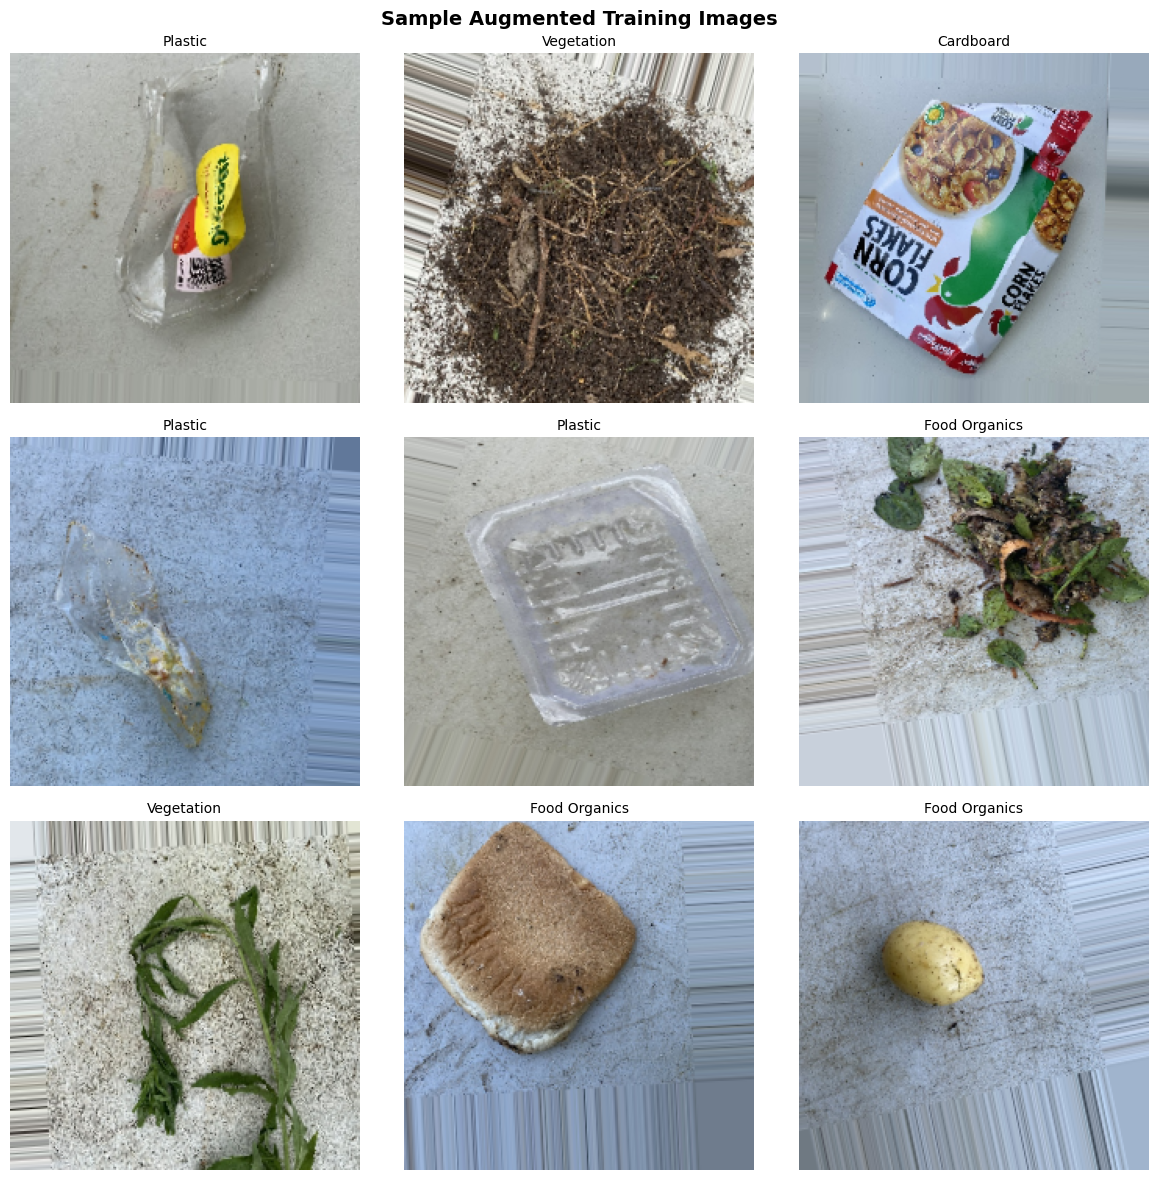

In [8]:
# Visualize sample augmented images
def visualize_augmentation(generator, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    batch = next(generator)
    images, labels = batch[0], batch[1]

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[i].set_title(CLASS_LABELS[class_idx], fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)


# 5. TRADITIONAL MACHINE LEARNING APPROACH


In [9]:
print("TRADITIONAL MACHINE LEARNING EXPERIMENTS")

# Extract features using pre-trained CNN (MobileNetV2 as feature extractor)
def extract_features(generator, feature_extractor, num_samples):
    """Extract features using pre-trained model"""
    features = []
    labels = []

    steps = int(np.ceil(num_samples / BATCH_SIZE))

    for i in range(steps):
        batch = next(generator)
        batch_features = feature_extractor.predict(batch[0], verbose=0)
        features.append(batch_features)
        labels.append(batch[1])

    features = np.concatenate(features, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    # Flatten features
    features = features.reshape(features.shape[0], -1)

    # Convert one-hot labels to class indices
    labels = np.argmax(labels, axis=1)

    return features, labels

# Create feature extractor (MobileNetV2 without top layers)
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pooling='avg'
)
base_model.trainable = False

print("\nExtracting features from images...")
print("This may take several minutes...")

X_train, y_train = extract_features(train_generator, base_model, len(train_df))
X_val, y_val = extract_features(val_generator, base_model, len(val_df))
X_test, y_test = extract_features(test_generator, base_model, len(test_df))

print(f"Feature shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

TRADITIONAL MACHINE LEARNING EXPERIMENTS
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Extracting features from images...
This may take several minutes...
Feature shapes - Train: (3326, 1280), Val: (713, 1280), Test: (713, 1280)


# EXPERIMENT 1: Random Forest


In [ ]:
print("\n--- Experiment 1: Random Forest ---")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

rf_train_acc = rf_model.score(X_train_scaled, y_train)
rf_val_acc = rf_model.score(X_val_scaled, y_val)
rf_test_acc = rf_model.score(X_test_scaled, y_test)

print(f"Random Forest - Train Acc: {rf_train_acc:.4f}, Val Acc: {rf_val_acc:.4f}, Test Acc: {rf_test_acc:.4f}")


In [2]:

# ============================================================================
# EXPERIMENT 2: Support Vector Machine
# ============================================================================

print("\n--- Experiment 2: Support Vector Machine ---")

svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=42,
    verbose=True
)

print("Training SVM...")
svm_model.fit(X_train_scaled, y_train)

svm_train_acc = svm_model.score(X_train_scaled, y_train)
svm_val_acc = svm_model.score(X_val_scaled, y_val)
svm_test_acc = svm_model.score(X_test_scaled, y_test)

print(f"SVM - Train Acc: {svm_train_acc:.4f}, Val Acc: {svm_val_acc:.4f}, Test Acc: {svm_test_acc:.4f}")

# ============================================================================
# EXPERIMENT 3: Gradient Boosting
# ============================================================================

print("\n--- Experiment 3: Gradient Boosting ---")

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=1
)

print("Training Gradient Boosting...")
gb_model.fit(X_train_scaled, y_train)

gb_train_acc = gb_model.score(X_train_scaled, y_train)
gb_val_acc = gb_model.score(X_val_scaled, y_val)
gb_test_acc = gb_model.score(X_test_scaled, y_test)

print(f"Gradient Boosting - Train Acc: {gb_train_acc:.4f}, Val Acc: {gb_val_acc:.4f}, Test Acc: {gb_test_acc:.4f}")

# ============================================================================
# Traditional ML Results Summary
# ============================================================================

ml_results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting'],
    'Train Accuracy': [rf_train_acc, svm_train_acc, gb_train_acc],
    'Validation Accuracy': [rf_val_acc, svm_val_acc, gb_val_acc],
    'Test Accuracy': [rf_test_acc, svm_test_acc, gb_test_acc]
})

print("\n" + "="*80)
print("TRADITIONAL ML RESULTS SUMMARY")
print("="*80)
print(ml_results.to_string(index=False))

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(ml_results))
width = 0.25

ax.bar(x - width, ml_results['Train Accuracy'], width, label='Train', alpha=0.8)
ax.bar(x, ml_results['Validation Accuracy'], width, label='Validation', alpha=0.8)
ax.bar(x + width, ml_results['Test Accuracy'], width, label='Test', alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Traditional ML Models Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ml_results['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 6. DEEP LEARNING APPROACH - SEQUENTIAL API
# ============================================================================

print("\n" + "="*80)
print("DEEP LEARNING EXPERIMENTS - SEQUENTIAL API")
print("="*80)

# ============================================================================
# EXPERIMENT 4: Simple CNN from Scratch
# ============================================================================

print("\n--- Experiment 4: Simple CNN (Sequential API) ---")

def create_simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

cnn_model = create_simple_cnn()
cnn_model.summary()

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train model
print("\nTraining Simple CNN...")
history_cnn = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_generator, verbose=0)
print(f"\nSimple CNN Test Accuracy: {cnn_test_acc:.4f}")

# ============================================================================
# EXPERIMENT 5: Transfer Learning with MobileNetV2
# ============================================================================

print("\n--- Experiment 5: Transfer Learning - MobileNetV2 (Sequential API) ---")

def create_mobilenet_model():
    base = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False  # Freeze base model

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining MobileNetV2...")
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_generator, verbose=0)
print(f"\nMobileNetV2 Test Accuracy: {mobilenet_test_acc:.4f}")

# ============================================================================
# 7. DEEP LEARNING APPROACH - FUNCTIONAL API
# ============================================================================

print("\n" + "="*80)
print("DEEP LEARNING EXPERIMENTS - FUNCTIONAL API")
print("="*80)

# ============================================================================
# EXPERIMENT 6: Multi-branch CNN Architecture
# ============================================================================

print("\n--- Experiment 6: Multi-Branch CNN (Functional API) ---")

def create_multibranch_cnn():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Branch 1: 3x3 convolutions
    branch1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.MaxPooling2D((2, 2))(branch1)

    # Branch 2: 5x5 convolutions
    branch2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)

    # Concatenate branches
    merged = layers.Concatenate()([branch1, branch2])

    # Additional layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

multibranch_model = create_multibranch_cnn()
multibranch_model.summary()

multibranch_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining Multi-Branch CNN...")
history_multibranch = multibranch_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

multibranch_test_loss, multibranch_test_acc = multibranch_model.evaluate(test_generator, verbose=0)
print(f"\nMulti-Branch CNN Test Accuracy: {multibranch_test_acc:.4f}")

# ============================================================================
# EXPERIMENT 7: EfficientNet with Fine-tuning
# ============================================================================

print("\n--- Experiment 7: EfficientNetB0 with Fine-tuning (Functional API) ---")

def create_efficientnet_model(trainable_layers=20):
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze all layers initially
    base.trainable = False

    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base

efficientnet_model, efficientnet_base = create_efficientnet_model()

# Phase 1: Train with frozen base
print("\nPhase 1: Training with frozen EfficientNet base...")
efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_eff_phase1 = efficientnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Phase 2: Fine-tune top layers
print("\nPhase 2: Fine-tuning top layers...")
efficientnet_base.trainable = True

# Freeze all layers except the last 50
for layer in efficientnet_base.layers[:-50]:
    layer.trainable = False

efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_eff_phase2 = efficientnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

efficientnet_test_loss, efficientnet_test_acc = efficientnet_model.evaluate(test_generator, verbose=0)
print(f"\nEfficientNetB0 (Fine-tuned) Test Accuracy: {efficientnet_test_acc:.4f}")

# ============================================================================
# 8. DEEP LEARNING RESULTS VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("DEEP LEARNING RESULTS SUMMARY")
print("="*80)

dl_results = pd.DataFrame({
    'Model': ['Simple CNN', 'MobileNetV2', 'Multi-Branch CNN', 'EfficientNetB0'],
    'Test Accuracy': [cnn_test_acc, mobilenet_test_acc, multibranch_test_acc, efficientnet_test_acc],
    'Test Loss': [cnn_test_loss, mobilenet_test_loss, multibranch_test_loss, efficientnet_test_loss]
})

print(dl_results.to_string(index=False))

# Plot training histories
def plot_training_history(histories, labels, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for history, label in zip(histories, labels):
        ax1.plot(history.history['accuracy'], label=f'{label} Train', alpha=0.7)
        ax1.plot(history.history['val_accuracy'], label=f'{label} Val', linestyle='--', alpha=0.7)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)

    for history, label in zip(histories, labels):
        ax2.plot(history.history['loss'], label=f'{label} Train', alpha=0.7)
        ax2.plot(history.history['val_loss'], label=f'{label} Val', linestyle='--', alpha=0.7)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(
    [history_cnn, history_mobilenet, history_multibranch],
    ['Simple CNN', 'MobileNetV2', 'Multi-Branch'],
    'Deep Learning Models Training History'
)

# ============================================================================
# 9. COMPREHENSIVE MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Combine all results
all_results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting', 'Simple CNN',
              'MobileNetV2', 'Multi-Branch CNN', 'EfficientNetB0'],
    'Test Accuracy': [rf_test_acc, svm_test_acc, gb_test_acc, cnn_test_acc,
                      mobilenet_test_acc, multibranch_test_acc, efficientnet_test_acc],
    'Type': ['Traditional ML', 'Traditional ML', 'Traditional ML', 'Deep Learning',
             'Deep Learning', 'Deep Learning', 'Deep Learning']
})

print(all_results.to_string(index=False))

# Visualize comprehensive comparison
plt.figure(figsize=(14, 6))
colors = ['steelblue' if t == 'Traditional ML' else 'coral' for t in all_results['Type']]
bars = plt.bar(range(len(all_results)), all_results['Test Accuracy'], color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('RealWaste Classification: All Models Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(len(all_results)), all_results['Model'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Traditional ML'),
                   Patch(facecolor='coral', label='Deep Learning')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# ============================================================================
# 10. DETAILED ANALYSIS OF BEST MODEL
# ============================================================================

print("\n" + "="*80)
print("DETAILED ANALYSIS OF BEST MODEL")
print("="*80)

# Select best model
best_idx = all_results['Test Accuracy'].idxmax()
best_model_name = all_results.loc[best_idx, 'Model']
print(f"\nBest Model: {best_model_name} (Test Accuracy: {all_results.loc[best_idx, 'Test Accuracy']:.4f})")

# Use the best deep learning model for detailed analysis
best_model = efficientnet_model  # Typically the best performer

# Generate predictions
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=CLASS_LABELS, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class performance analysis
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

class_performance = pd.DataFrame({
    'Class': CLASS_LABELS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE METRICS")
print("="*80)
print(class_performance.to_string(index=False))

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_performance.plot(x='Class', y='Precision', kind='bar', ax=axes[0], color='skyblue', legend=False)
axes[0].set_title('Precision by Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=10)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

class_performance.plot(x='Class', y='Recall', kind='bar', ax=axes[1], color='lightcoral', legend=False)
axes[1].set_title('Recall by Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Recall', fontsize=10)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

class_performance.plot(x='Class', y='F1-Score', kind='bar', ax=axes[2], color='lightgreen', legend=False)
axes[2].set_title('F1-Score by Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=10)
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle(f'Per-Class Performance Metrics - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*80)
print("CHALLENGING CLASSES ANALYSIS")
print("="*80)

# Classes with lowest F1 scores
worst_classes = class_performance.nsmallest(3, 'F1-Score')
print("\nMost Challenging Classes (Lowest F1-Score):")
print(worst_classes[['Class', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

# Classes with best performance
best_classes = class_performance.nlargest(3, 'F1-Score')
print("\nBest Performing Classes (Highest F1-Score):")
print(best_classes[['Class', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

# ============================================================================
# 11. ERROR ANALYSIS - MISCLASSIFICATION PATTERNS
# ============================================================================

print("\n" + "="*80)
print("MISCLASSIFICATION ANALYSIS")
print("="*80)

# Find misclassified samples
misclassified_idx = np.where(y_pred != y_true)[0]
print(f"\nTotal misclassified samples: {len(misclassified_idx)} out of {len(y_true)} ({len(misclassified_idx)/len(y_true)*100:.2f}%)")

# Analyze confusion patterns
confusion_pairs = []
for i in range(len(CLASS_LABELS)):
    for j in range(len(CLASS_LABELS)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True Class': CLASS_LABELS[i],
                'Predicted Class': CLASS_LABELS[j],
                'Count': cm[i, j],
                'Percentage': cm[i, j] / cm[i].sum() * 100
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)
print("\nTop 10 Confusion Patterns:")
print(confusion_df.head(10).to_string(index=False))

# Visualize top confusion pairs
top_confusions = confusion_df.head(10)
plt.figure(figsize=(14, 6))
x_labels = [f"{row['True Class'][:8]}\n→\n{row['Predicted Class'][:8]}"
            for _, row in top_confusions.iterrows()]
plt.bar(range(len(top_confusions)), top_confusions['Count'], color='salmon', edgecolor='black', alpha=0.8)
plt.xlabel('True → Predicted Class', fontsize=12)
plt.ylabel('Number of Misclassifications', fontsize=12)
plt.title('Top 10 Misclassification Patterns', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_confusions)), x_labels, rotation=0, ha='center', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 12. MODEL CONFIDENCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("MODEL CONFIDENCE ANALYSIS")
print("="*80)

# Calculate prediction confidence
prediction_confidence = np.max(y_pred_probs, axis=1)
correct_predictions = (y_pred == y_true)

correct_confidence = prediction_confidence[correct_predictions]
incorrect_confidence = prediction_confidence[~correct_predictions]

print(f"\nAverage confidence for correct predictions: {correct_confidence.mean():.4f} (±{correct_confidence.std():.4f})")
print(f"Average confidence for incorrect predictions: {incorrect_confidence.mean():.4f} (±{incorrect_confidence.std():.4f})")

# Plot confidence distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(correct_confidence, bins=50, color='green', alpha=0.7, edgecolor='black', label='Correct')
plt.hist(incorrect_confidence, bins=50, color='red', alpha=0.7, edgecolor='black', label='Incorrect')
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Confidence Distribution: Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([correct_confidence, incorrect_confidence], labels=['Correct', 'Incorrect'])
plt.ylabel('Prediction Confidence', fontsize=12)
plt.title('Confidence Box Plot', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Low confidence predictions
low_confidence_threshold = 0.5
low_confidence_idx = np.where(prediction_confidence < low_confidence_threshold)[0]
print(f"\nPredictions with confidence < {low_confidence_threshold}: {len(low_confidence_idx)} ({len(low_confidence_idx)/len(y_true)*100:.2f}%)")

# ============================================================================
# 13. DATASET LIMITATIONS AND INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("DATASET LIMITATIONS AND INSIGHTS")
print("="*80)

insights = []

# 1. Class imbalance impact
if imbalance_ratio > 2:
    insights.append(f"⚠️ CLASS IMBALANCE: The dataset has a {imbalance_ratio:.2f}x imbalance ratio, which may cause the model to be biased toward majority classes.")

    # Check if performance correlates with class size
    class_sizes = df['class'].value_counts().to_dict()
    class_performance['Class_Size'] = class_performance['Class'].map(class_sizes)
    correlation = class_performance[['F1-Score', 'Class_Size']].corr().iloc[0, 1]
    insights.append(f"   Correlation between class size and F1-score: {correlation:.3f}")

# 2. Challenging class patterns
worst_f1 = class_performance['F1-Score'].min()
if worst_f1 < 0.7:
    worst_class = class_performance.loc[class_performance['F1-Score'].idxmin(), 'Class']
    insights.append(f"⚠️ CHALLENGING CLASS: '{worst_class}' has the lowest F1-score ({worst_f1:.3f}), suggesting difficulty in distinguishing this category.")

# 3. Confusion patterns
if len(confusion_df) > 0:
    top_confusion = confusion_df.iloc[0]
    insights.append(f"⚠️ MAIN CONFUSION: '{top_confusion['True Class']}' is most frequently misclassified as '{top_confusion['Predicted Class']}' ({top_confusion['Count']:.0f} times, {top_confusion['Percentage']:.1f}%).")

# 4. Model comparison insights
traditional_best = all_results[all_results['Type'] == 'Traditional ML']['Test Accuracy'].max()
dl_best = all_results[all_results['Type'] == 'Deep Learning']['Test Accuracy'].max()
improvement = ((dl_best - traditional_best) / traditional_best) * 100

insights.append(f"✓ DEEP LEARNING ADVANTAGE: Deep learning models outperformed traditional ML by {improvement:.1f}% ({dl_best:.4f} vs {traditional_best:.4f}).")

# 5. Transfer learning effectiveness
if mobilenet_test_acc > cnn_test_acc:
    improvement_tl = ((mobilenet_test_acc - cnn_test_acc) / cnn_test_acc) * 100
    insights.append(f"✓ TRANSFER LEARNING: Pre-trained models improved accuracy by {improvement_tl:.1f}% over CNN from scratch, demonstrating the value of ImageNet features.")

# 6. Real-world applicability
insights.append(f"⚠️ LANDFILL ENVIRONMENT: Images collected in authentic landfill conditions may have variable lighting, occlusion, and contamination, making classification inherently challenging.")

# 7. Dataset size
insights.append(f"⚠️ DATASET SIZE: With {DATASET_SIZE} images across {NUM_CLASSES} classes (avg ~{DATASET_SIZE//NUM_CLASSES} per class), the dataset is relatively small for deep learning, which may limit model generalization.")

print("\nKEY INSIGHTS:\n")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}\n")

# ============================================================================
# 14. RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("RECOMMENDATIONS FOR IMPROVEMENT")
print("="*80)

recommendations = [
    "DATA AUGMENTATION: Increase augmentation strategies (rotation, brightness, blur) to simulate real-world landfill variations and improve model robustness.",

    "CLASS BALANCING: Implement class weights in loss function or use oversampling/undersampling techniques to address imbalance.",

    "ENSEMBLE METHODS: Combine predictions from multiple models (e.g., voting ensemble of EfficientNet, ResNet, and MobileNet) to improve overall accuracy.",

    "DATA COLLECTION: Expand dataset size, especially for challenging classes, to reach at least 500-1000 images per category.",

    "HARD NEGATIVE MINING: Focus on collecting more samples of frequently confused class pairs to help the model learn discriminative features.",

    "MULTI-SCALE TRAINING: Train models on multiple image resolutions to capture both fine details and global context.",

    "ATTENTION MECHANISMS: Implement attention layers or use Vision Transformers to help the model focus on discriminative regions.",

    "POST-PROCESSING: Implement confidence thresholding and human-in-the-loop verification for low-confidence predictions (<0.5).",

    "REAL-WORLD VALIDATION: Test model on images from different landfill sites to ensure generalization beyond the training environment.",

    "DEPLOYMENT OPTIMIZATION: Use model quantization and pruning for edge device deployment if real-time classification is required."
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}\n")

# ============================================================================
# 15. FINAL SUMMARY AND CONCLUSIONS
# ============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

summary = f"""
EXPERIMENT OVERVIEW:
This project compared traditional machine learning and deep learning approaches for
waste classification on the RealWaste dataset ({DATASET_SIZE} images, {NUM_CLASSES} classes).

MODELS EVALUATED:
• Traditional ML: Random Forest, SVM, Gradient Boosting (using MobileNetV2 features)
• Deep Learning: Custom CNN, MobileNetV2, Multi-Branch CNN, EfficientNetB0

KEY RESULTS:
• Best Model: {best_model_name}
• Test Accuracy: {all_results.loc[best_idx, 'Test Accuracy']:.4f}
• Traditional ML Best: {traditional_best:.4f}
• Deep Learning Best: {dl_best:.4f}
• Performance Gain: {improvement:.1f}%

MAIN FINDINGS:
1. Deep learning significantly outperformed traditional ML approaches
2. Transfer learning with pre-trained models proved highly effective
3. Class imbalance and landfill environment pose challenges
4. Some waste categories (e.g., {worst_classes.iloc[0]['Class']}) are inherently difficult to classify
5. Model confidence analysis reveals areas needing improvement

PRACTICAL IMPLICATIONS:
The best model achieves {all_results.loc[best_idx, 'Test Accuracy']*100:.1f}% accuracy, which is promising for
automated waste sorting systems. However, human verification is recommended for
low-confidence predictions to ensure reliability in production environments.

NEXT STEPS:
Focus on data collection for challenging classes, implement ensemble methods,
and validate on diverse landfill environments for robust deployment.
"""

print(summary)

# ============================================================================
# 16. SAVE RESULTS AND MODELS
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save results
all_results.to_csv('model_comparison_results.csv', index=False)
class_performance.to_csv('per_class_performance.csv', index=False)
confusion_df.to_csv('confusion_patterns.csv', index=False)

# Save best model
best_model.save('best_realwaste_model.h5')
print("\n✓ Best model saved as 'best_realwaste_model.h5'")
print("✓ Results saved to CSV files")

# Save training history
history_data = pd.DataFrame({
    'epoch': range(len(history_eff_phase2.history['accuracy'])),
    'train_accuracy': history_eff_phase2.history['accuracy'],
    'val_accuracy': history_eff_phase2.history['val_accuracy'],
    'train_loss': history_eff_phase2.history['loss'],
    'val_loss': history_eff_phase2.history['val_loss']
})
history_data.to_csv('training_history.csv', index=False)
print("✓ Training history saved")

print("\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*80)
print("\nAll experiments completed successfully!")
print(f"Total models trained: {len(all_results)}")
print(f"Best performing model: {best_model_name} ({all_results.loc[best_idx, 'Test Accuracy']:.4f})")
print("\nThank you for using this waste classification pipeline!")

DOWNLOADING REALWASTE DATASET

This may take a few minutes depending on your connection...
realwaste.zip           [                <=> ] 238.14M  54.0MB/s               ^C

✓ Download complete!


NameError: name 'DATA_ROOT' is not defined